## Training the Vision Transformer on a Custom Dataset

In this notebook, we are going to fine-tune a pre-trained Vision Transformer (which can be found from [Huggingface](https://github.com/huggingface/transformers)) on a Custom Dataset. For this notebook we will be using the Rock, Paper, Scissors dataset which can be found [here](https://public.roboflow.com/classification/rock-paper-scissors/1). This dataset is a collection of 2925 images images in 3 different classes. This tutorial is based on Huggingface's [Fine tuning the Vision Transformer on CIFAR 10 notebook](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb).

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [How to Train the HuggingFace Vision Transformer On a Custom Dataset](blog.roboflow.com/how-to-train-the-huggingface-vision-transformer-on-a-custom-dataset/) concurrently.


We will prepare the data using [Roboflow's Preprocessing Tools](https://docs.roboflow.com/image-transformations/image-preprocessing), and train the model using this notebook. 

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train a Vision Transformer on your custom classification data.

To train our image classifier we take the following steps:

* Install Vision Transformer dependencies
* Download custom Image Classification data using Roboflow
* Use the Vision Transformer Feature Extractor
* Run the Vision Transformer training procedure
* Evaluate the Vision Transformer on a test image
* Export the Vision Transformer model for future inference


### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)



Let's start by installing the relevant libraries.

In [1]:
!pip install  git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-sysrepgy
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-sysrepgy
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.22.0.dev0-py3-none-any.whl size=4680065 sha256=1fd02ef0d738dab5b28618d29c760695a9292dc9842ba1eb2cce1743ae86727f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ri28y8uw/wheels/42/68/45/c63edff61c292f2dfd4df4ef6522dcbecc603e7af82813c1d7
Successfully built transformers


# Download the Data 

We'll preprocess and download our dataset from Roboflow. To preprocess the images, change the size of the image to 224x224. To download the dataset, use the "**Folder Structure**" export format.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

Note: This data has already been preprocessed through Roboflow; we HIGHLY reccommend you follow the [accompanying blog](blog.roboflow.com/how-to-train-the-huggingface-vision-transformer-on-a-custom-dataset/) as you go through this notebook.

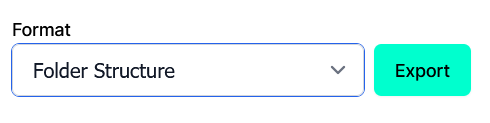

In [ ]:
! curl -L "https://public.roboflow.com/ds/gftCVSMv3D?key=vwKEKfMVWU" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Next, convert the folder structure dataset into a PyTorch dataset format using PyTorch's ImageFolder dataset structure:

In [11]:
import torchvision
from torchvision import transforms

Transform = transforms.Compose([transforms.Resize(size=(224, 224)), transforms.ToTensor()])


train_ds = torchvision.datasets.ImageFolder('/root/vit/data/train', transform=Transform)
valid_ds = torchvision.datasets.ImageFolder('/root/vit/data/valid/', transform=Transform)
test_ds = torchvision.datasets.ImageFolder('/root/vit/data/test/', transform=Transform)

In [15]:
train_ds

Dataset ImageFolder
    Number of datapoints: 630
    Root location: /root/vit/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

## Define the Model

Here we define the model.

The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.

**Note:** The Vision Transformer pretrained model can be used as a regular PyTorch layer.


To train this model, we will train in 3 epochs, with a batch size of 10 and a learning rate of 2e-5:

In [21]:
## variables settings

Num_Lables = 3
Pre_Trained_Model = 'google/vit-base-patch16-224-in21k'
ViT_Feature_Extractor = 'google/vit-base-patch16-224-in21k'
EPOCHS = 30
BATCH_SIZE = 2
LEARNING_RATE = 2e-5
Num_Workers = 4
SHUFFLE = True

In [17]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels=Num_Lables):
        super(ViTForImageClassification, self).__init__()
        self.vit = ViTModel.from_pretrained(Pre_Trained_Model)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels):
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:,0])
        logits = self.classifier(output)

        loss = None
        if labels is not None:
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        if loss is not None:
          return logits, loss.item()
        else:
          return logits, None

## Define the Model Parameters


We will use the pretrained Vision Transformer feature extractor, an Adam Optimizer, and a Cross Entropy Loss function.

In [18]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)
print(torch.cuda.is_available())

cuda
True


In [19]:
# Define Model
model = ViTForImageClassification(len(train_ds.classes))    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained(ViT_Feature_Extractor)
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

## Train the Model

In [22]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np

print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx) 

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE,  num_workers=Num_Workers)
test_loader  = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=Num_Workers) 

# Train the model
for epoch in range(EPOCHS):        
  for step, (x, y) in enumerate(train_loader):
    # Change input array into list with each batch being one element
    x = np.split(np.squeeze(np.array(x)), BATCH_SIZE)
    # Remove unecessary dimension
    for index, array in enumerate(x):
      x[index] = np.squeeze(array)
    # Apply feature extractor, stack back into 1 tensor and then convert to tensor
    x = torch.tensor(np.stack(feature_extractor(x)['pixel_values'], axis=0))
    # Send to GPU if available
    x, y  = x.to(device), y.to(device)
    b_x = Variable(x)   # batch x (image)
    b_y = Variable(y)   # batch y (target)
    # Feed through model
    output, loss = model(b_x, None)
    # Calculate loss
    if loss is None: 
      loss = loss_func(output, b_y)   
      optimizer.zero_grad()           
      loss.backward()                 
      optimizer.step()

    if step % 50 == 0:
      # Get the next batch for testing purposes
      test = next(iter(test_loader))
      test_x = test[0]
      # Reshape and get feature matrices as needed
      test_x = np.split(np.squeeze(np.array(test_x)), BATCH_SIZE)
      for index, array in enumerate(test_x):
        test_x[index] = np.squeeze(array)
      test_x = torch.tensor(np.stack(feature_extractor(test_x)['pixel_values'], axis=0))
      # Send to appropirate computing device
      test_x = test_x.to(device)
      test_y = test[1].to(device)
      # Get output (+ respective class) and compare to target
      test_output, loss = model(test_x, test_y)
      test_output = test_output.argmax(1)
      # Calculate Accuracy
      accuracy = (test_output == test_y).sum().item() / BATCH_SIZE
      print('Epoch: ', epoch, '| train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

Number of train samples:  630
Number of test samples:  90
Detected Classes are:  {'paper': 0, 'rock': 1, 'scissors': 2}
Epoch:  0 | train loss: 0.0488 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0372 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0357 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0283 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0278 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0292 | test accuracy: 1.00
Epoch:  0 | train loss: 0.0209 | test accuracy: 1.00
Epoch:  1 | train loss: 0.0241 | test accuracy: 1.00
Epoch:  1 | train loss: 0.0207 | test accuracy: 1.00
Epoch:  1 | train loss: 0.0203 | test accuracy: 1.00
Epoch:  1 | train loss: 0.0192 | test accuracy: 1.00
Epoch:  1 | train loss: 0.0147 | test accuracy: 1.00
Epoch:  1 | train loss: 0.0160 | test accuracy: 1.00
Epoch:  1 | train loss: 0.0141 | test accuracy: 1.00
Epoch:  2 | train loss: 0.0148 | test accuracy: 1.00
Epoch:  2 | train loss: 0.0147 | test accuracy: 1.00
Epoch:  2 | train loss: 0.0153 |

## Evaluate on a Test Image

Finally, let's evaluate the model on a test image:

torch.Size([1, 3, 224, 224])


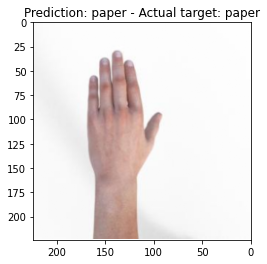

In [23]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
# Disable grad
with torch.no_grad():
    
  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed
  print(inputs.shape)
  inputs = inputs[0].permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)
 
  # Generate prediction
  prediction, loss = model(inputs, target)
    
  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
  value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
        
  # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()

## Save the Entire Model

We can save the entire model as follows:

In [ ]:
torch.save(model, '/content/model.pt')

## Export Trained Model

Now that you have trained your custom vision transformer, you can export the trained model you have made here for inference on your device elsewhere

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cp /content/model.pt /content/gdrive/My\ Drive

Mounted at /content/gdrive


## Use your Exported Model

In [ ]:
MODEL_PATH = '/content/model.pt'
model = torch.load(MODEL_PATH)
model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea